# Вебинар 3. Коллаборативная фильтрация

Исчерпывающую информацию с теорией, кодом и примерами можно найти в [статье](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

# 1. Матричная факторизация
### Матричное разложение

Раскладываем user-item матрицу на 2: матрицу латентных факторов юзеров и матрицу латентных факторов товаров

- латентый фактор = эмбеддинг (embedding)    

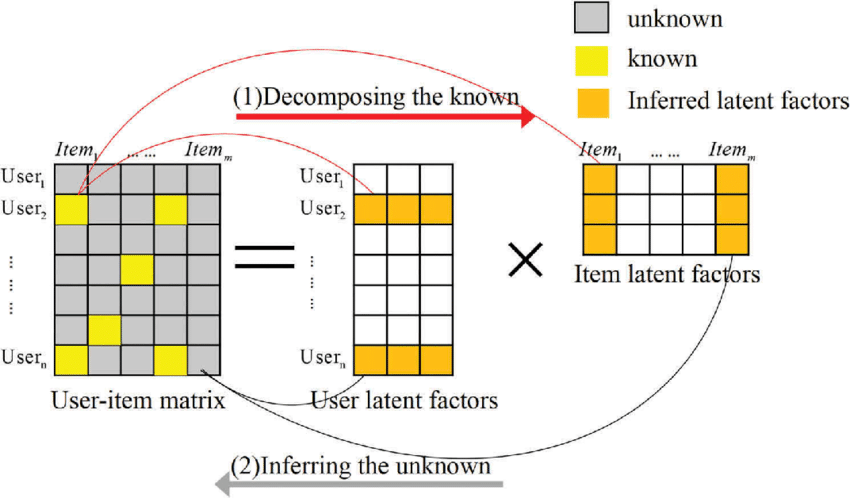

(UхI) = (Uхk) * (kхI) 

---

## Alternating Least Squares (ALS)

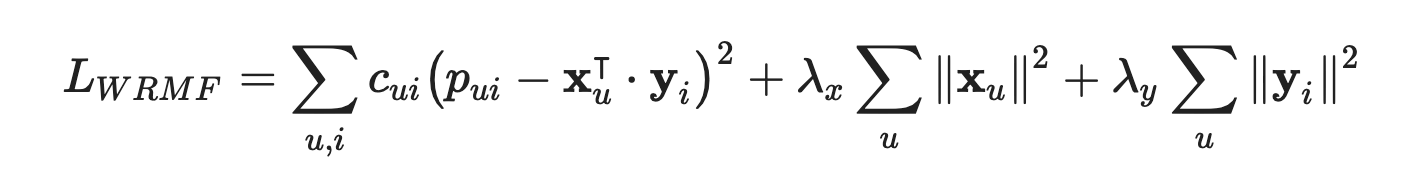

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Алгоритм**  
ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах):  

1. Фиксируем эмбеддинги юзеров $x_u^T$ --> легко посчитать производную по эмбеддингам товаров $y_i$
2. Обновляем эмбеддинги товаров (делаем шаг по антиградиенту = градиентный спуск)
3. Фиксируем эмбеддинги товаров $y_i$ --> легко посчитать производную по эмбеддингам юзеров $x_u^T$
4. Обновляем эмбеддинги юзеров (делаем шаг по антиградиенту = градиентный спуск)
5. Повторяем, пока процедура не сойдется

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть регуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cyton - очень быстро работает
- Predict для *всех* юзеров можно сделать прост оперемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


In [8]:
data = pd.read_csv('data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [9]:
item_features = pd.read_csv('data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [10]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [11]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [49]:
# Заведем фиктивный item_id (если юзер не покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix_q_M = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='max', 
                                  fill_value=0
                                 )
user_item_matrix_q_sum = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )
user_item_matrix_v_M = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробовать другие варианты
                                  aggfunc='max', 
                                  fill_value=0
                                 )

user_item_matrix_q_M = user_item_matrix_q_M.astype(float) # необходимый тип матрицы для implicit
user_item_matrix_q_M = user_item_matrix_q_sum.astype(float)
user_item_matrix_q_M = user_item_matrix_v_M.astype(float)

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix_q_M).tocsr()
sparse_user_item_2 = csr_matrix(user_item_matrix_q_sum).tocsr()
sparse_user_item_3 = csr_matrix(user_item_matrix_v_M).tocsr()



user_item_matrix_q_M.head(3)

/Users/maximcucer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
user_item_matrix_q_M.shape

(2499, 5001)

In [36]:
userids_q_M = user_item_matrix_q_M.index.values
itemids_q_M = user_item_matrix_q_M.columns.values

matrix_userids_q_M = np.arange(len(userids_q_M))
matrix_itemids_q_M = np.arange(len(itemids_q_M))

id_to_itemid_q_M = dict(zip(matrix_itemids_q_M, itemids_q_M))
id_to_userid_q_M = dict(zip(matrix_userids_q_M, userids_q_M))

itemid_to_id_q_M = dict(zip(itemids_q_M, matrix_itemids_q_M))
userid_to_id_q_M = dict(zip(userids_q_M, matrix_userids_q_M))

In [51]:
userids_q_sum = user_item_matrix_q_sum.index.values
itemids_q_sum = user_item_matrix_q_sum.columns.values

matrix_userids_q_sum = np.arange(len(userids_q_sum))
matrix_itemids_q_sum = np.arange(len(itemids_q_sum))

id_to_itemid_q_sum = dict(zip(matrix_itemids_q_sum, itemids_q_sum))
id_to_userid_q_sum = dict(zip(matrix_userids_q_sum, userids_q_sum))

itemid_to_id_q_sum = dict(zip(itemids_q_sum, matrix_itemids_q_sum))
userid_to_id_q_sum = dict(zip(userids_q_sum, matrix_userids_q_sum))

In [52]:
userids_v_M = user_item_matrix_v_M.index.values
itemids_v_M = user_item_matrix_v_M.columns.values

matrix_userids_v_M = np.arange(len(userids_v_M))
matrix_itemids_v_M = np.arange(len(itemids_v_M))

id_to_itemid_v_M = dict(zip(matrix_itemids_v_M, itemids_v_M))
id_to_userid_v_M = dict(zip(matrix_userids_v_M, userids_v_M))

itemid_to_id_v_M = dict(zip(itemids_v_M, matrix_itemids_v_M))
userid_to_id_v_M = dict(zip(userids_v_M, matrix_userids_v_M))

In [53]:
%%time

model_1 = AlternatingLeastSquares(factors=100, #k f
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model_1.fit(csr_matrix(user_item_matrix_q_M).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs_1 = model_1.recommend(userid=userid_to_id_q_M[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_q_M).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 16.4 s, sys: 2.42 s, total: 18.9 s
Wall time: 7.99 s


In [54]:
%%time

model_2 = AlternatingLeastSquares(factors=100, #k f
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model_2.fit(csr_matrix(user_item_matrix_q_sum).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs_2 = model_2.recommend(userid=userid_to_id_q_sum[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_q_sum).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 16.2 s, sys: 2.61 s, total: 18.8 s
Wall time: 8.53 s


In [168]:
%%time

model_3 = AlternatingLeastSquares(factors=100, #k f
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model_3.fit(csr_matrix(user_item_matrix_v_M).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs_3 = model_3.recommend(userid=userid_to_id_v_M[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_v_M).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 16.4 s, sys: 2.63 s, total: 19 s
Wall time: 8.76 s


In [57]:
def get_recommendations(user, model, method, N=5):
    if method == 'q_M':
        res = [id_to_itemid_q_M[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id_q_M[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    elif method == 'q_sum':
         res = [id_to_itemid_q_sum[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id_q_sum[user], 
                                    user_items=sparse_user_item_2,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    else:
        res = [id_to_itemid_v_M[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id_v_M[user], 
                                    user_items=sparse_user_item_3,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [58]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision


In [86]:
%%time
    
result['als_q_M'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model_1, method='q_M', N=5))
result.apply(lambda row: precision_at_k(row['als_q_M'], row['actual']), axis=1).mean()

CPU times: user 37.5 s, sys: 3.54 s, total: 41.1 s
Wall time: 22.1 s


0.12957884427032218

In [84]:
%%time
    
result['als_q_sum'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model_2, method='q_sum', N=5))
result.apply(lambda row: precision_at_k(row['als_q_sum'], row['actual']), axis=1).mean()

CPU times: user 38.2 s, sys: 3.77 s, total: 41.9 s
Wall time: 23 s


0.1468168462291854

In [85]:
%%time
    
result['als_v_M'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model_3, method='v_M', N=5))
result.apply(lambda row: precision_at_k(row['als_v_M'], row['actual']), axis=1).mean()

CPU times: user 37.6 s, sys: 3.47 s, total: 41 s
Wall time: 21.8 s


0.12840352595494486

По результатам precision метрике можем заметить что лучше всего показала себя модель суммирующая сколько
всего пользователей купил данный товар, а не те где эмбединги отображали макисмальную стоимость или максимальное
количество покупок. Этот факт наводит на мысль что так как модель ALS строит embeding лучше всего на
explicit данных, quantity_sum лучше остальных показывает склоность пользователя к покупке, и взаимосвязь 
более похожа на линейную

In [98]:
?AlternatingLeastSquares

(Я не нашел как получить веса из AlternatingLeastSquares)

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [166]:
?AlternatingLeastSquares

In [116]:
lst = []

In [ ]:
for factors in [10, 60, 100, 150]:
    for regularization in [0.01, 0.001, 0.0001]:
        model = AlternatingLeastSquares(factors=factors, #k f
                                regularization=regularization,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

        model.fit(csr_matrix(user_item_matrix_q_sum).T.tocsr())

        result['als_q_sum'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, method='q_sum', N=5))
        prec = result.apply(lambda row: precision_at_k(row['als_q_sum'], row['actual']), axis=1).mean()
        
        lst.append([factors, regularization, prec])
        

In [130]:
lst = np.array(lst)
df = pd.DataFrame(lst, columns=['factors', 'regularization', 'precision'])

In [132]:
df.head()

,factors,regularization,precision
0,10.0,0.0100,0.139961
1,10.0,0.0010,0.152400
2,10.0,0.0001,0.147405
3,60.0,0.0100,0.146915
4,60.0,0.0010,0.148874


In [143]:
df.loc[df['precision'] == float(df.agg({'precision':max}))]

,factors,regularization,precision
1,10.0,0.001,0.1524


лучше всего себя показала модель с factors = 10 и regularization = 0.001

In [144]:
import matplotlib.pyplot as plt

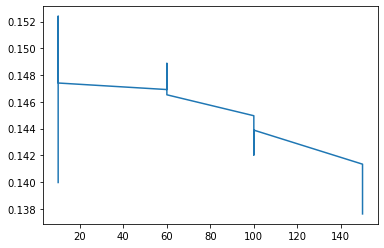

In [160]:
plt.plot(df.factors, df.precision)

In [163]:
df.sort_values(by='regularization', inplace=True)

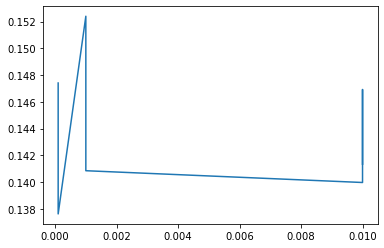

In [164]:
plt.plot(df.regularization, df.precision)

Естественно что при увеличении n_factors растет и время обучения так как проводятся больше вычислений.
Наш research показал что более простая модель с n_factors=10 лучше описывает данные 
при regularization=0.001. Я предпологаю что в данном случае, для описания клиента нужны не так много
чисел, так как в случае модели с весами матрицы user_item(количество купленного товара) пользователя
по настоящему описывают именно те товары которые он покупает в большем количестве
